In [ ]:
"""
 full braycurtis to compare fingerprints: 
 - dBm valus are adjusted from -95..-30 to 0-1
 - common APs are found 
 - difference between APs is taken, as in Fang et al [Calibration free approaches]
 - extra APs are added with their actual power or -95dBm when missing cf Beder & Klepal 2012
 - similarity function (braycurtis/correlation/cosine/...) is called 
 - thresholds for similarities returned are 0.25-0.35 for 2m
 - floors and clusters are hopefully at > 1.0  
 - notebook test results for precis-01 and precis-02 datasets 
"""

In [172]:
from utils import *
import numpy as np
import sys, os, random
# from compare_locations import compare_locations

datadir = "../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json"]



In [17]:
datadir = "../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
"1-pixel-25-02-2021_21-16-46.json.gz",
"2-pixel-25-02-2021_16-27-45.json.gz",
"3-pixel-04-03-2021_16-18-50.json.gz",
"4-pixel-04-03-2021_16-43-50.json.gz",
"5-pixel-04-03-2021_17-11-32.json.gz",
"6-pixel-17-03-2021_12-52-29.json.gz",
"7-pixel-17-03-2021_13-14-36.json.gz"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
"2-redmi-25-02-2021_16-27-08.json.gz",
"3-redmi-04-03-2021_16-18-52.json.gz",
"4-redmi-04-03-2021_16-43-45.json.gz",
"5-redmi-04-03-2021_17-11-30.json.gz",
"6-redmi-17-03-2021_12-52-29.json.gz",
"7-redmi-17-03-2021_13-14-39.json.gz"]



In [173]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)



In [174]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    petaje.append(etaj)
    

bc  0.1217809185733281 [0.00076452] [0.15156684]


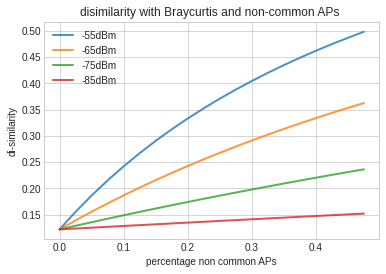

In [170]:
# this portion needs rssi1 and rssi2 from compare locations, before 
#they are passed to braycurtis 
q,p = compare_locations(retaje[0][1], retaje[0][2], dif=True, simil_method=braycurtis)

print("bc ", braycurtis(q[0:20], p[0:20]), adjust_rssi(-95.0), adjust_rssi(-65.0))
#print(q)
q, p = q[0:20], p[0:20]
l = len(q) 
bc_curve = dict()
for pow in [-55, -65, -75, -85]:
    bcx = []
    for i in range(0, l):
        bcx.append(braycurtis(q + list(adjust_rssi(-95.0)* np.ones(i)), 
                            p + list(1.0*adjust_rssi(pow)* np.ones(i))))
    bc_curve[pow] = np.arange(0, 0.5, 0.5/l), bcx  

#print(bc_curve)    
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(6, 4))     # bc, realbc, iou   

for pow in [-55, -65, -75, -85]:
    plt.plot(bc_curve[pow][0] , bc_curve[pow][1], "-", label=f"{pow}dBm", linewidth=2, alpha=0.8)

plt.xlabel('percentage non common APs')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"disimilarity with Braycurtis and non-common APs ")
#plt.xticks(range(0, 20, 2))
#plt.xlim(0, 0.55)
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"braycurtis-noncommon-APs-near.pdf", bbox_inches='tight')

In [175]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = retaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
minra = []
for e in range(0,len(etaje)): 
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q+1,len(etaje[e])):
            if p > q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 7.0: 
                    continue
                bc = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=braycurtis)
                #cor = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                #                              dif=True, simil_method=cosine)
                
                R = 2.0
                if bc < 0.34: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                    
                bd.append([ q, p, eu_dist, bc, cor])
after = datetime.datetime.now()

print(f"R= {R} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f}")
print(f"Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

R= 2.0 Precision= 0.55 Recall= 0.99
Pdist = [1.90816378 4.253      5.26075351] 
Slope = 0.07


###precis-02 redmi-redmi 
-R = 2.0 bc < 0.29/avg Precision = 0.47 Recall = 0.99 FP up to 4.8m 95% 
-R = 2.0 bc < 0.32/max Precision = 0.51 Recall = 0.99 FP up to 4.4m 95% 
-R = 2.5 bc < 0.35/max Precision = 0.55 Recall = 0.99 FP up to 4.8m 95% 
-R = 3.0 bc < 0.38/max Precision = 0.56 Recall = 0.99 FP up to 5.1m 95% 
braycurtis ~ cosine ~ correlation 
R = 2.0 cor<0.11/avg/nodiff Precision = 0.56 Recall = 0.99 FP up to 4.2m 95%  - BEST 
R = 2.0 rbc < 0.25/avg/diff Precision= 0.52 Recall= 0.99 FP up to 4.2m 95% 
R = 2.0 fbc < 0.34/dif/adj Precision= 0.55 Recall= 0.99 Pdist = 4.2 95% - ACCEPT 
R = 6.5 fbc < 0.7 Precision= 0.92 Recall= 0.99 FP 6.6m 

###precis-01 redmi-redmi 
-R= 2.0m bc < 0.23/Avg Precision= 0.35 Recall= 0.99 false positives up to @5.3m 95% 
-R= 2.5m bc < 0.28/Avg Precision= 0.49 Recall= 0.99 false positives up to @5.8m 95% 
-R= 4.0m bc < 0.39/Avg Precision= 0.61 Recall= 0.99 false positives up to @6.4m 95% 
-R= 2.0m realbc<0.22/avg/diff Precision= 0.36 Recall= 0.99 FP up to 4.6m 95% - BEST 
-R= 2.0m fbc < 0.3/diff/adj Prec = 0.36 Rec=0.99 FP up to 4.7m @95% - ACCEPT 
-R= 5.0m fbc < 0.5/dif/adj prec= 0.73 FP up to 6.4m 
-R= 7.0m fbc < 0.7         prc = 0.75 FP up to 9.1m


Slope = [0.00067076 0.06693579 0.11039722]


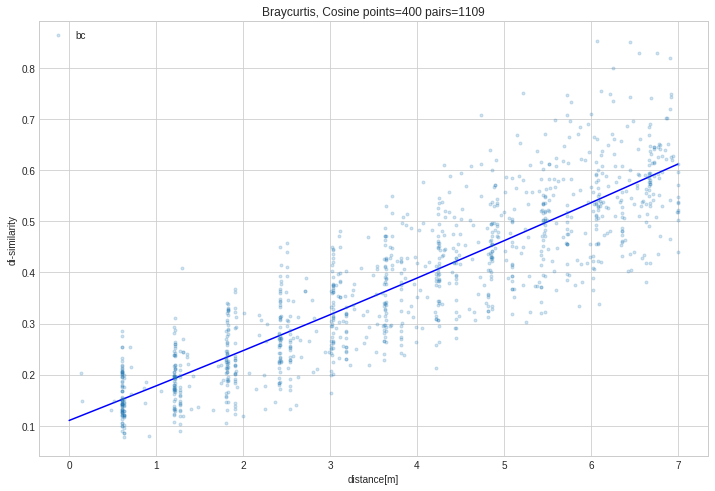

In [182]:
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(12, 8))     # bc, realbc, iou   
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
print(f"Slope = {m}")
predict = np.poly1d(m)
x_lin_reg = range(0, 8)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')

plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('distance[m]')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Braycurtis, Cosine points={npct} pairs={len(bd)}")
#plt.xticks(range(0, 20, 2))
#plt.ylim(0, 0.5)
#plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()

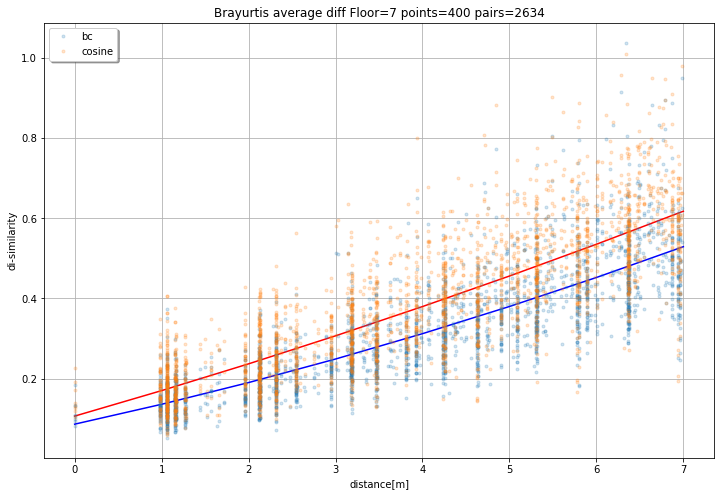


In [179]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average'):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], braycurtis, selection)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average'):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1000.0 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], braycurtis, dif=True)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  
    

In [180]:
print(adjust_rssi(-80.0))

[0.03310993]


In [181]:
#  query = Pixel  
#  DB = redmi 
cl_sim = []
cl_steps = []
cl_dist = []

#for e in len(retaje):
for e in range(0, len(petaje)): 
    for p in range(0, len(petaje[e])):
        sim, index, d =  test_queryvsall(petaje[e][p], retaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        #cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)
        
for e in range(0, len(retaje)): 
    for p in range(0, len(retaje[e])):
        sim, index, d =  test_queryvsall(retaje[e][p], petaje[e], 'Average')
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        #cl_steps.append(diff_modulo(p, index, len(petaje[e])))
        cl_dist.append(d)

        
print(np.percentile(cl_dist, [50, 95, 99]))

[0.608      1.67511104 2.24934528]


precis-02 cross validation 
fbc + diff/adj  [0.608      1.67511104 2.24934528]

precis-01, cross validation 
fbc + diff/adj  [1.06       2.38321704 3.47432727]

real + True [0.98153846 2.12666667]
bc + True [0.98153846 2.12666667 2.55557152]


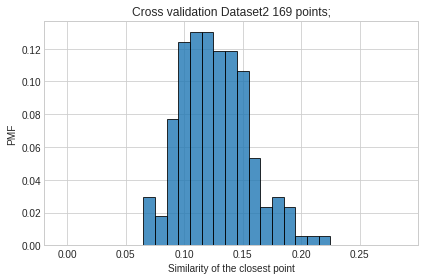

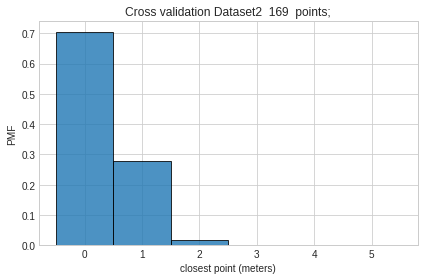

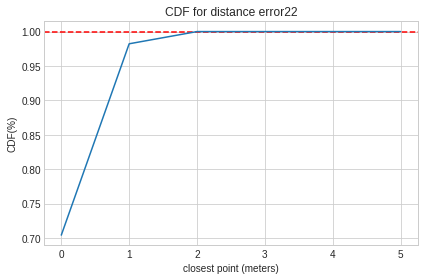

In [183]:

b = np.arange(0, 0.3, 0.01) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_sim), b, density=False)
hist_sim = hist_sim / len(cl_sim)
plt.style.use("seaborn-whitegrid")   
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("Similarity of the closest point")
plt.ylabel("PMF")
plt.title("{} {}{}".format("Cross validation Dataset2", len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
fig.savefig(f"disim-cross-dataset2.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

b = np.arange(0, 7, 1) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]
hist_sim, bins_out = np.histogram(np.array(cl_dist), b, density=False)
hist_sim = hist_sim / len(cl_sim)
fig = plt.figure()
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.8)
plt.xlabel("closest point (meters)")
plt.ylabel("PMF")
plt.title("{} {} {}".format("Cross validation Dataset2 ", len(cl_sim), " points;"))
plt.tight_layout()
plt.show()
fig.savefig(f"dist-closest-cross-dataset2.pdf", bbox_inches='tight')
#    print("Percentages: ", hist_away)

cdf=np.cumsum(hist_sim)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("closest point (meters)")
plt.ylabel("CDF(%)")
plt.title("{}{}".format("CDF for distance error", 22))
plt.plot(b[:-1], cdf)
plt.grid(True)
plt.tight_layout()
plt.show()



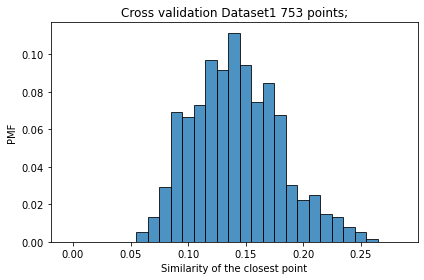
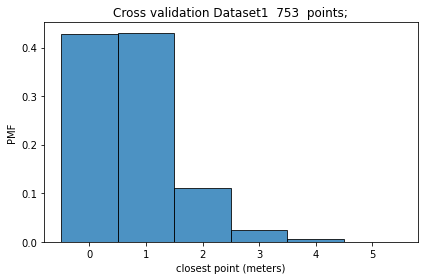
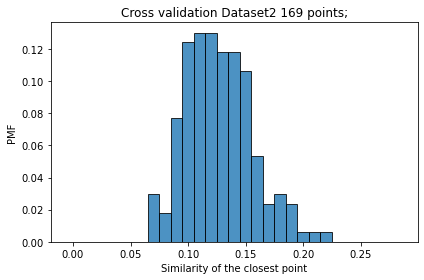
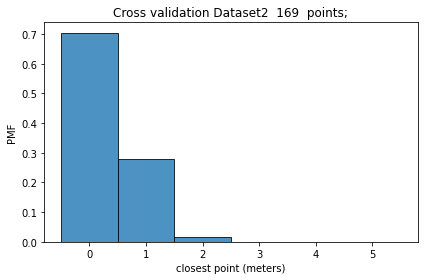
